# Exploratory Data Analysis

## Setting the environment up

1.  Loading main packages

In [ ]:
library(here)
library(data.table)
library(lubridate)
library(ggplot2)
library(scales)
library(forcats)
library(patchwork)
theme_set(theme_light())

source(here("R/02-custom-functions.R"))
source(here("R/03-custom-values.R"))

1.  Importing zone codes

In [ ]:
ZoneCodes <- fread(
  here("data/taxi_zone_lookup.csv"),
  select = ZoneCodesColTypes
)

1.  Importing and decoding training data.

In [ ]:
DecodedTrips <- fst::read_fst(
  path = here("data/TripDataTrain.fst"),
  as.data.table = TRUE
) |>
  decode_zones(ZoneCodes) |>
  decode_business()

setnames(DecodedTrips, "bcf","back_car_fund")

## Exploring variable distribution

The purpose of this section is to:

-   Understand the meaning of each variable and compare results with
    current domain knolege
-   Find hidden missing values
-   Find usual values

### Categorical variables distribution

-   `company`: The majority number of trips are done by *Uber* (HV003)
    and the rest for *Lyft*.

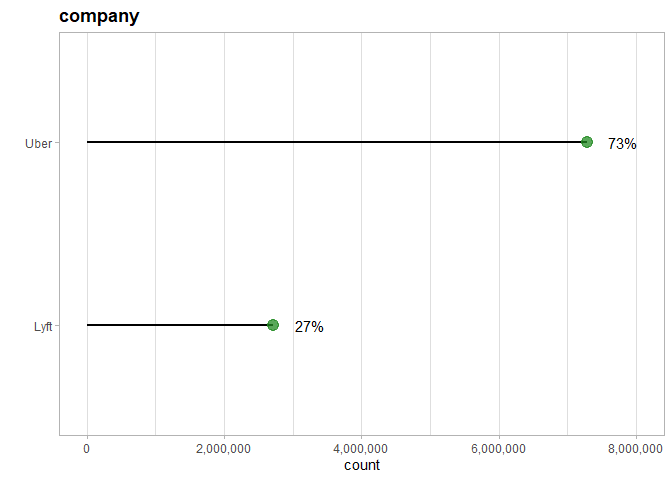

In [ ]:
plot_chr_count(DecodedTrips, "company")

-   `dispatching_base_num`: This column doesn’t show much information,
    so we will **erase** this column as it doesn’t show any useful
    information.

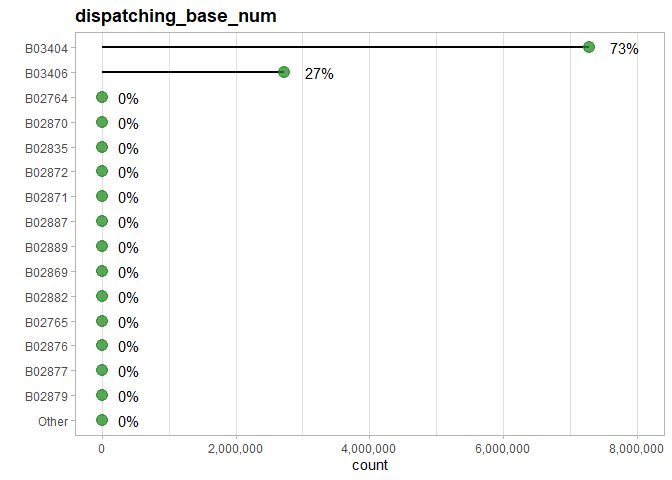

In [ ]:
plot_chr_count(DecodedTrips, "dispatching_base_num")

-   `originating_base_num`: This column doesn’t show much information,
    so we will **erase** this column as it doesn’t show any useful
    information.

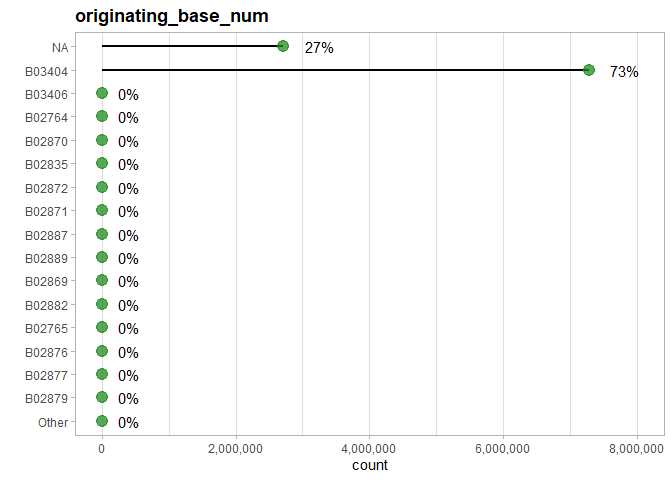

In [ ]:
plot_chr_count(DecodedTrips, "originating_base_num")

-   `shared_request_flag`: Most of passengers don’t agree to a
    shared/pooled ride.

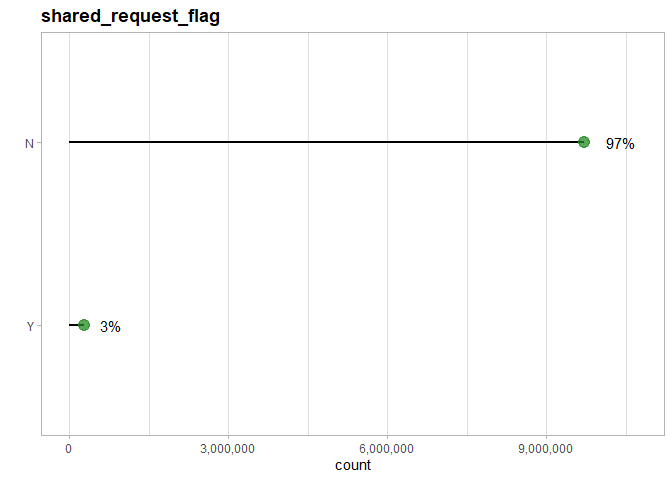

In [ ]:
plot_chr_count(DecodedTrips, "shared_request_flag")

-   `shared_match_flag`: Shows that actually fewer trips were shared.

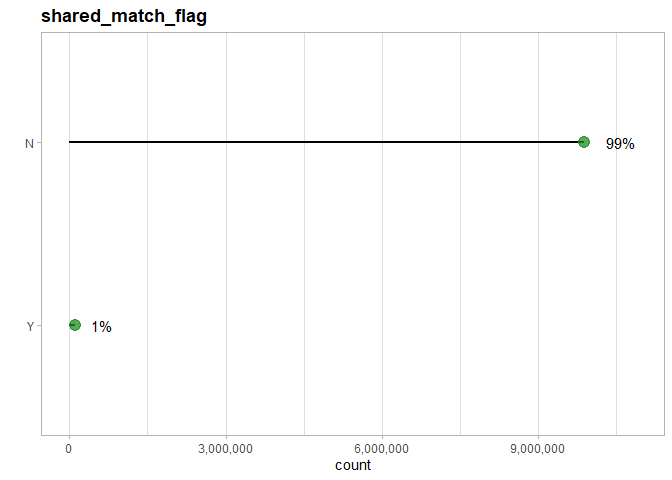

In [ ]:
plot_chr_count(DecodedTrips, "shared_match_flag")

-   `access_a_ride_flag`: *Uber* isn’t reporting whether their trips
    were administered on behalf of the Metropolitan Transportation
    Authority and for *Lyft* the answer is always “N”, so we will
    **erase** this column as it doesn’t show any useful information.

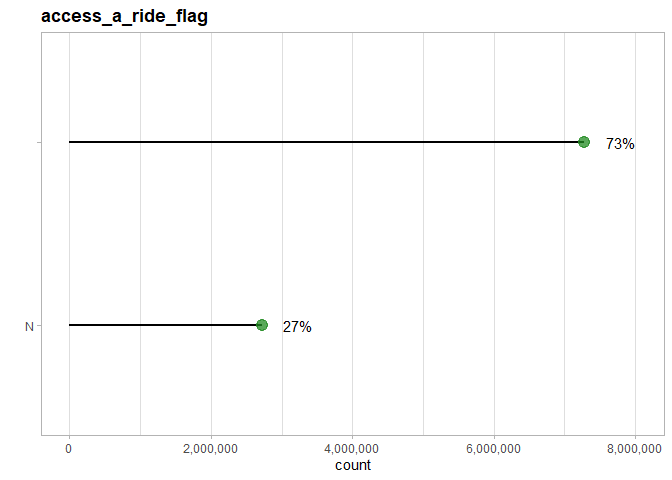

   company access_a_ride_flag       N
1:    Uber                    7282646
2:    Lyft                  N 2717354

In [ ]:
plot_chr_count(DecodedTrips, "access_a_ride_flag")

-   `wav_request_flag`: It’s really unusual for a passager to request a
    wheelchair-accessible vehicle.

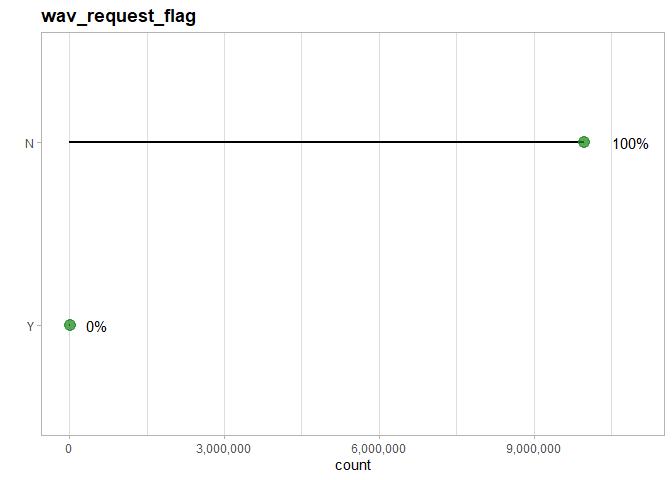

   wav_request_flag       N
1:                N 9984507
2:                Y   15493

In [ ]:
plot_chr_count(DecodedTrips, "wav_request_flag")

-   `wav_match_flag`: 7% of trips took place in wheelchair-accessible
    vehicle which implies that there is more offers than demand.

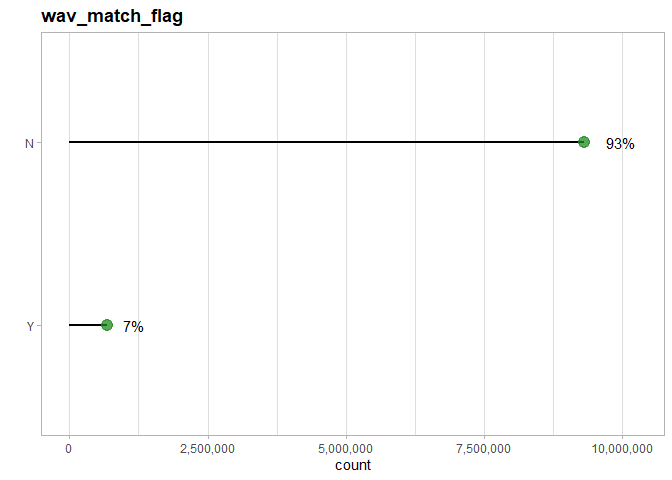

In [ ]:
plot_chr_count(DecodedTrips, "wav_match_flag")

-   For `start_Borough` and `end_Borough` tt’s weird to start or end the
    trips in Stalen Island or the EWR Airport. We will need to
    **inputate** the Unknown level.

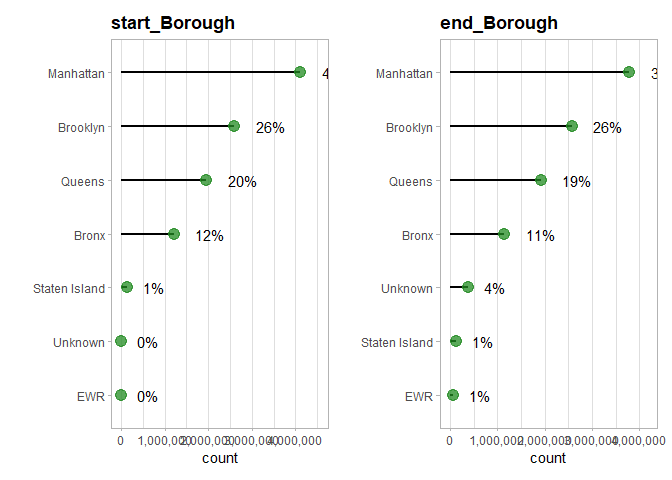

In [ ]:
ggBorough1 <- plot_chr_count(DecodedTrips, "start_Borough")

ggBorough2 <- plot_chr_count(DecodedTrips, "end_Borough")

ggBorough1 + ggBorough2

-   For `start_service_zone` and `end_service_zone` It’s weird to start
    or end the trips in any Airports. For consistency we will **relabel
    EWR as Airpots** and **impute** “N/A” values.

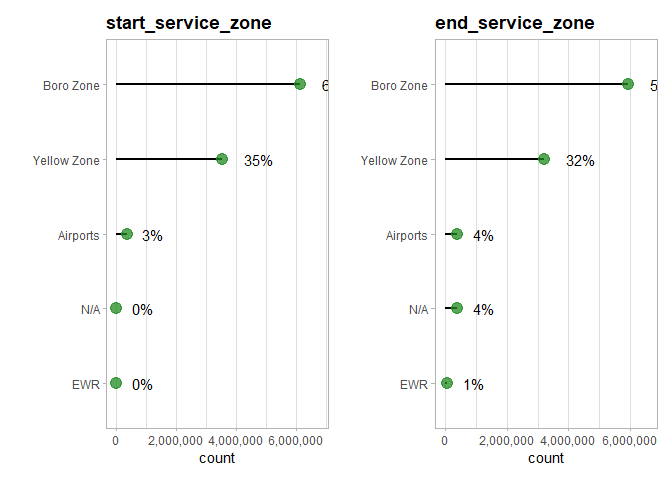

In [ ]:
ggServiceZone1 <- plot_chr_count(DecodedTrips, "start_service_zone")

ggServiceZone2 <- plot_chr_count(DecodedTrips, "end_service_zone")

ggServiceZone1 + ggServiceZone2

At this point is important to explain that in NYC cabs operate different
depending on its color:

-   **Yellow cabs**: They have no restrictions when it comes to travel.

-   **Green cabs**: They can only pick up passengers in Harlem (south of
    West 110th St and East 96th St), Queens, the Bronx and Brooklyn —
    excluding the airports but **can drop passengers off anywhere** in
    New York City.

> Uber and Lyft doesn’t any restriction at traveling.

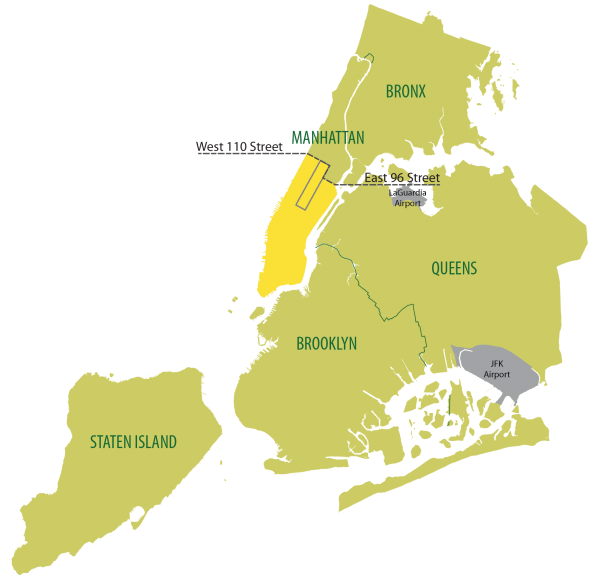

-   `start_Zone` and `end_Zone` represent a diverse number of places as
    theirs higher proportion of trips is lower then 3% with the
    exception of the “N/A” value that needs to be **erased and
    inputed**.

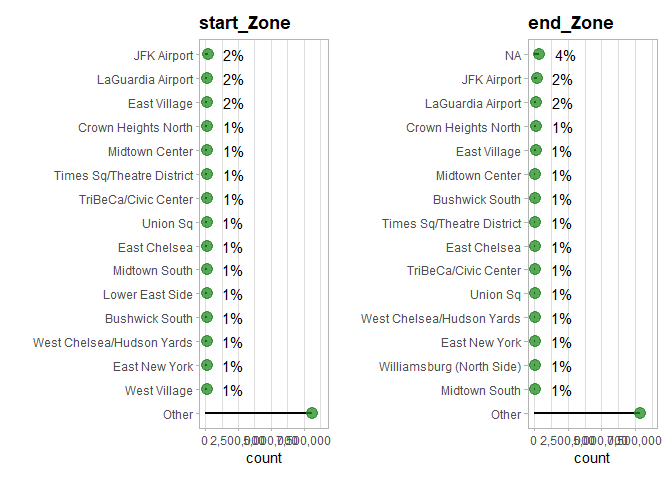

In [ ]:
ggZone1 <- plot_chr_count(DecodedTrips, "start_Zone")

ggZone2 <- plot_chr_count(DecodedTrips, "end_Zone")

ggZone1 + ggZone2

### Numerical variables distribution

Before checking any distribution chart let’s the summary statistics of
numeric vars.

In [ ]:
NumericSummary <-
  DecodedTrips[, .SD, .SDcols = is.numeric] |>
  skimr::skim()
  
setDT(NumericSummary) |> print()

    skim_type        skim_variable n_missing complete_rate numeric.mean
 1:   numeric           trip_miles         0             1    4.8785285
 2:   numeric            trip_time         0             1 1120.4671601
 3:   numeric  base_passenger_fare         0             1   22.4701755
 4:   numeric                tolls         0             1    1.0415245
 5:   numeric        back_car_fund         0             1    0.7097493
 6:   numeric            sales_tax         0             1    1.9043467
 7:   numeric congestion_surcharge         0             1    1.1138906
 8:   numeric          airport_fee         0             1    0.1679533
 9:   numeric                 tips         0             1    0.9851154
10:   numeric           driver_pay         0             1   17.6956378
     numeric.sd numeric.p0 numeric.p25 numeric.p50 numeric.p75 numeric.p100
 1:   5.6741053       0.00        1.54        2.89        6.03       351.17
 2: 777.3435289       0.00      579.00      921.00     1

After checking that statistics we can say that:

1.  Numeric values has very different dimensions. So we will need to
    scale them before applying any method based on distances like PCA.

2.  Variables have **very high variability** as of theirs coefficient of
    variation are higher 0.50, specially for `airport_fee`, `tolls` and
    `tips`.

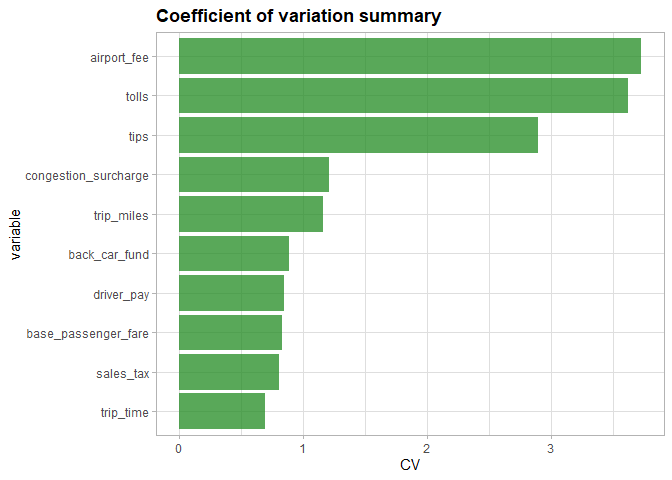

In [ ]:
NumericSummary[, .(variable = skim_variable,
                   CV = numeric.sd/numeric.mean)
  ][, variable := fct_reorder(variable, CV)] |>
  ggplot(aes(CV, variable))+
  geom_col(fill = "forestgreen", alpha = 0.75)+
  labs(title = "Coefficient of variation summary")+
  theme(plot.title = element_text(face = "bold"))

1.  `trip_miles`, `trip_time`, `base_passenger_fare`, `sales_tax` and
    `driver_pay` could be 0 of all of them a 0 at the same time,
    otherwise we need to **erase and input the values**.

2.  If `base_passenger_fare` and `driver_pay` are negative them we need
    to **erase and input the values** the passanger cannot charge the
    drive.

### Datetime variables distribution

In [ ]:
DatetimeSummary <-
  DecodedTrips[, .SD, .SDcols = is.POSIXct] |>
  skimr::skim()

setDT(DatetimeSummary) |> print()

   skim_type     skim_variable n_missing complete_rate         POSIXct.min
1:   POSIXct  request_datetime         0     1.0000000 2022-12-31 19:38:37
2:   POSIXct on_scene_datetime   2713591     0.7286409 2022-12-31 19:57:23
3:   POSIXct   pickup_datetime         0     1.0000000 2022-12-31 20:00:01
4:   POSIXct  dropoff_datetime         0     1.0000000 2022-12-31 20:04:38
           POSIXct.max      POSIXct.median POSIXct.n_unique
1: 2023-03-31 20:05:00 2023-02-16 11:52:19          5225266
2: 2023-03-31 19:59:52 2023-02-15 14:26:18          4435202
3: 2023-03-31 19:59:59 2023-02-16 11:57:34          5254993
4: 2023-03-31 22:27:33 2023-02-16 12:20:47          5250094

## MAPPING

In [ ]:
library(leaflet)

# Define the locations
data <- data.frame(adress = c("JFK Airport, Queens, NY, US",
                              "Briarwood/Jamaica Hills, Queens, NY, US"))


geo2 <- tidygeocoder::geocode(data, address = "adress", method = "arcgis")

# Calculate the distance
dist2 <- osrm::osrmRoute(
  src = geo2[1,c("long","lat")],
  dst = geo2[2,c("long","lat")],
  overview = "full"
)

# Print the distance in miles
print(dist2$distance * 0.621371)

[1] 7.939319

## References

-   Taxi color: https://newyorksimply.com/green-taxis-nyc-cab/